# CMIP6 Regional variable change

**Following steps are included in this script:**

1. Load netCDF files
2. Compute regional variable change
3. Plot change in reional parallel coordinate plots

## Import Packages

In [37]:
# ========== Packages ==========
import sys
import os
import xarray as xr
import pandas as pd
import numpy as np
import dask
from dask.diagnostics import ProgressBar
import importlib
import regionmask

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
data_vis_dir = '/work/ch0636/g300115/phd_project/common/src/visualization'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)
sys.path.append(data_vis_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as load_dat
import process_data as pro_dat
import compute_statistics as comp_stats
import colormaps as colmap
import parallel_coordinate_plots as par_coor_plot

from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

In [ ]:
importlib.reload(load_dat)
importlib.reload(pro_dat)
importlib.reload(comp_stats)
importlib.reload(colmap)
importlib.reload(par_coor_plot)

In [3]:
# For plotting
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
plt.rcParams['text.usetex'] = False
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb, textcomp}'

# For color map
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

#Check all possible fonts
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# Set the font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]

## Functions

In [11]:
def save_figure(fig, change, experiment_id, months, yearly_sum, region_names, region_idx, subdiv_idx, legend, common_scale_for_mm_day):
    # Caption and figure saving
    region_name = (region_names.isel(region=region_idx).item()).replace("/", "_")
    savepath = os.path.join('../..', 'results', 'CMIP6', period, 'time', 'mean', 'regional_var_change', region_name)
    os.makedirs(savepath, exist_ok=True)

    if legend:
        if common_scale_for_mm_day:
            filename = f'{region_name}_{subdiv_idx}_regional_var_{change}_{experiment_id}_{months}_{yearly_sum}.pdf'
        else:
            filename = f'{region_name}_{subdiv_idx}_regional_var_{change}_{experiment_id}_{months}_{yearly_sum}_no_common_y_scale.pdf' 
    else:
        if common_scale_for_mm_day:
            filename = f'{region_name}_{subdiv_idx}_regional_var_{change}_{experiment_id}_{months}_{yearly_sum}_without_legend.pdf' 

        else:
            filename = f'{region_name}_{subdiv_idx}_regional_var_{change}_{experiment_id}_{months}_{yearly_sum}_without_legend_no_common_y_scale.pdf' 
    filepath = os.path.join(savepath, filename)
    fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
    print(f'Figure saved under {filepath}')

## 1. Load and Preprocess

### 1.1 Load Data

In [12]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['historical', 'ssp370']
models = ['BCC-CSM2-MR', 'CESM2', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 
          'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-MM', 'UKESM1-0-LL']

variables=['tas', 'pr', 'vpd', 'evspsbl', 'evapo', 'tran', 'mrro', 'mrso', 'lai', 'gpp', 'wue', 'RX5day', 'gsl'] 
           
# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(load_dat.load_period_mean(BASE_DIR, data_state, data_product, experiments, models, variables, specific_months_or_seasons=None))[0]

Loading 'month' resolution variables ['tas', 'pr', 'vpd', 'evspsbl', 'evapo', 'tran', 'mrro', 'mrso', 'lai', 'gpp', 'wue'] for experiment 'historical'...
Selecting period 1985-2014 for 'month' variables in experiment 'historical'...
Computing period mean for 'month' variables in experiment 'historical'...
Loading 'year' resolution variable 'RX5day' for experiment 'historical'...
Computing period mean for 'year' variable in experiment 'historical'...
Loading 'period_mean' resolution variable 'gsl' for experiment 'historical'...
Merging all datasets for experiment 'historical'...
Loading 'month' resolution variables ['tas', 'pr', 'vpd', 'evspsbl', 'evapo', 'tran', 'mrro', 'mrso', 'lai', 'gpp', 'wue'] for experiment 'ssp370'...
Selecting period 2071-2100 for 'month' variables in experiment 'ssp370'...
Computing period mean for 'month' variables in experiment 'ssp370'...
Loading 'year' resolution variable 'RX5day' for experiment 'ssp370'...
Computing period mean for 'year' variable in expe

### 1.2 Compute Historical BGWS and Ensemble statsitics

In [13]:
ds_dict = pro_dat.compute_bgws(ds_dict)

In [14]:
ds_dict['historical'] = comp_stats.compute_ensemble_statistic(ds_dict['historical'], 'mean')
ds_dict['historical'] = comp_stats.compute_ensemble_statistic(ds_dict['historical'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


In [15]:
ds_dict['ssp370'] = comp_stats.compute_ensemble_statistic(ds_dict['ssp370'], 'mean')
ds_dict['ssp370'] = comp_stats.compute_ensemble_statistic(ds_dict['ssp370'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


### 1.3 Compute Changes and Ensemble statsitics

In [16]:
ds_dict_change = pro_dat.compute_change_dict(ds_dict)

Ensemble mean or median removed for keys: ['Ensemble mean', 'Ensemble median']


In [17]:
ds_dict_change['ssp370-historical'] = comp_stats.compute_ensemble_statistic(ds_dict_change['ssp370-historical'], 'mean')
ds_dict_change['ssp370-historical'] = comp_stats.compute_ensemble_statistic(ds_dict_change['ssp370-historical'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


### 1.4 Divide Data into Regions and Subdregions

In [18]:
ds_dict_region = {}
ds_dict_region = pro_dat.apply_region_mask(ds_dict, with_global=True)

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300115/.conda/envs/mypy3/share/proj failed


In [19]:
ds_dict_region_sub = {}
ds_dict_region_sub = pro_dat.subdivide_ds_dict_regions(ds_dict_region['historical'], 
                                                              ds_dict_region['historical'],  
                                                              'historical', 'historical', 'bgws')

In [20]:
ds_dict_change_region = {}
ds_dict_change_region = pro_dat.apply_region_mask(ds_dict_change, with_global=True)

In [21]:
ds_dict_change_region_sub = {}
ds_dict_change_region_sub = pro_dat.subdivide_ds_dict_regions(ds_dict_region['historical'], 
                                                              ds_dict_change_region['ssp370-historical'],  
                                                              'historical', 'ssp370-historical', 'bgws')

### 1.5 Compute Regional Means

In [22]:
ds_dict_region_mean = {}
ds_dict_region_mean = comp_stats.compute_regional_means(ds_dict_region)

In [23]:
ds_dict_region_sub_mean = {}
ds_dict_region_sub_mean = comp_stats.compute_spatial_mean_with_subdivisions(ds_dict_region_sub)

In [24]:
ds_dict_change_region_mean = {}
ds_dict_change_region_mean = comp_stats.compute_regional_means(ds_dict_change_region)

In [25]:
ds_dict_change_region_sub_mean = {}
ds_dict_change_region_sub_mean = comp_stats.compute_spatial_mean_with_subdivisions(ds_dict_change_region_sub)

## 2. Plot Parallel Coordinate Plots

In [47]:
#dpr = ds_dict_change_region_mean['ssp370-historical']['Ensemble mean'].pr.isel(region=18).values.item()
#print(f'Precipitation change: {dpr}')
#dmrro = ds_dict_change_region_mean['ssp370-historical']['Ensemble mean'].mrro.isel(region=18).values.item()
#print(f'Runoff change: {dmrro}')
#dtran = ds_dict_change_region_mean['ssp370-historical']['Ensemble mean'].tran.isel(region=18).values.item()
#print(f'Transpiration change: {dtran}')
#dbgws = ds_dict_change_region_mean['ssp370-historical']['Ensemble mean'].bgws.isel(region=18).values.item()
#print(f'delta BGWS: {dbgws}')
##Compute BGWS change based on variables
#bgws_d = ((dmrro - dtran)/dpr) * 100
#print(f'BGWS_delta: {dbgws}')

In [26]:
selected_variables = ['tas', 'vpd', 'RX5day', 
                      'pr', 'mrro', 'tran', 
                      'evapo', 'evspsbl', 'mrso', 
                      'lai', 'gpp', 'wue', 'gsl', 'bgws']

### Regional Anaylsis

In [45]:
importlib.reload(par_coor_plot)

<module 'parallel_coordinate_plots' from '/work/ch0636/g300115/phd_project/common/src/visualization/parallel_coordinate_plots.py'>

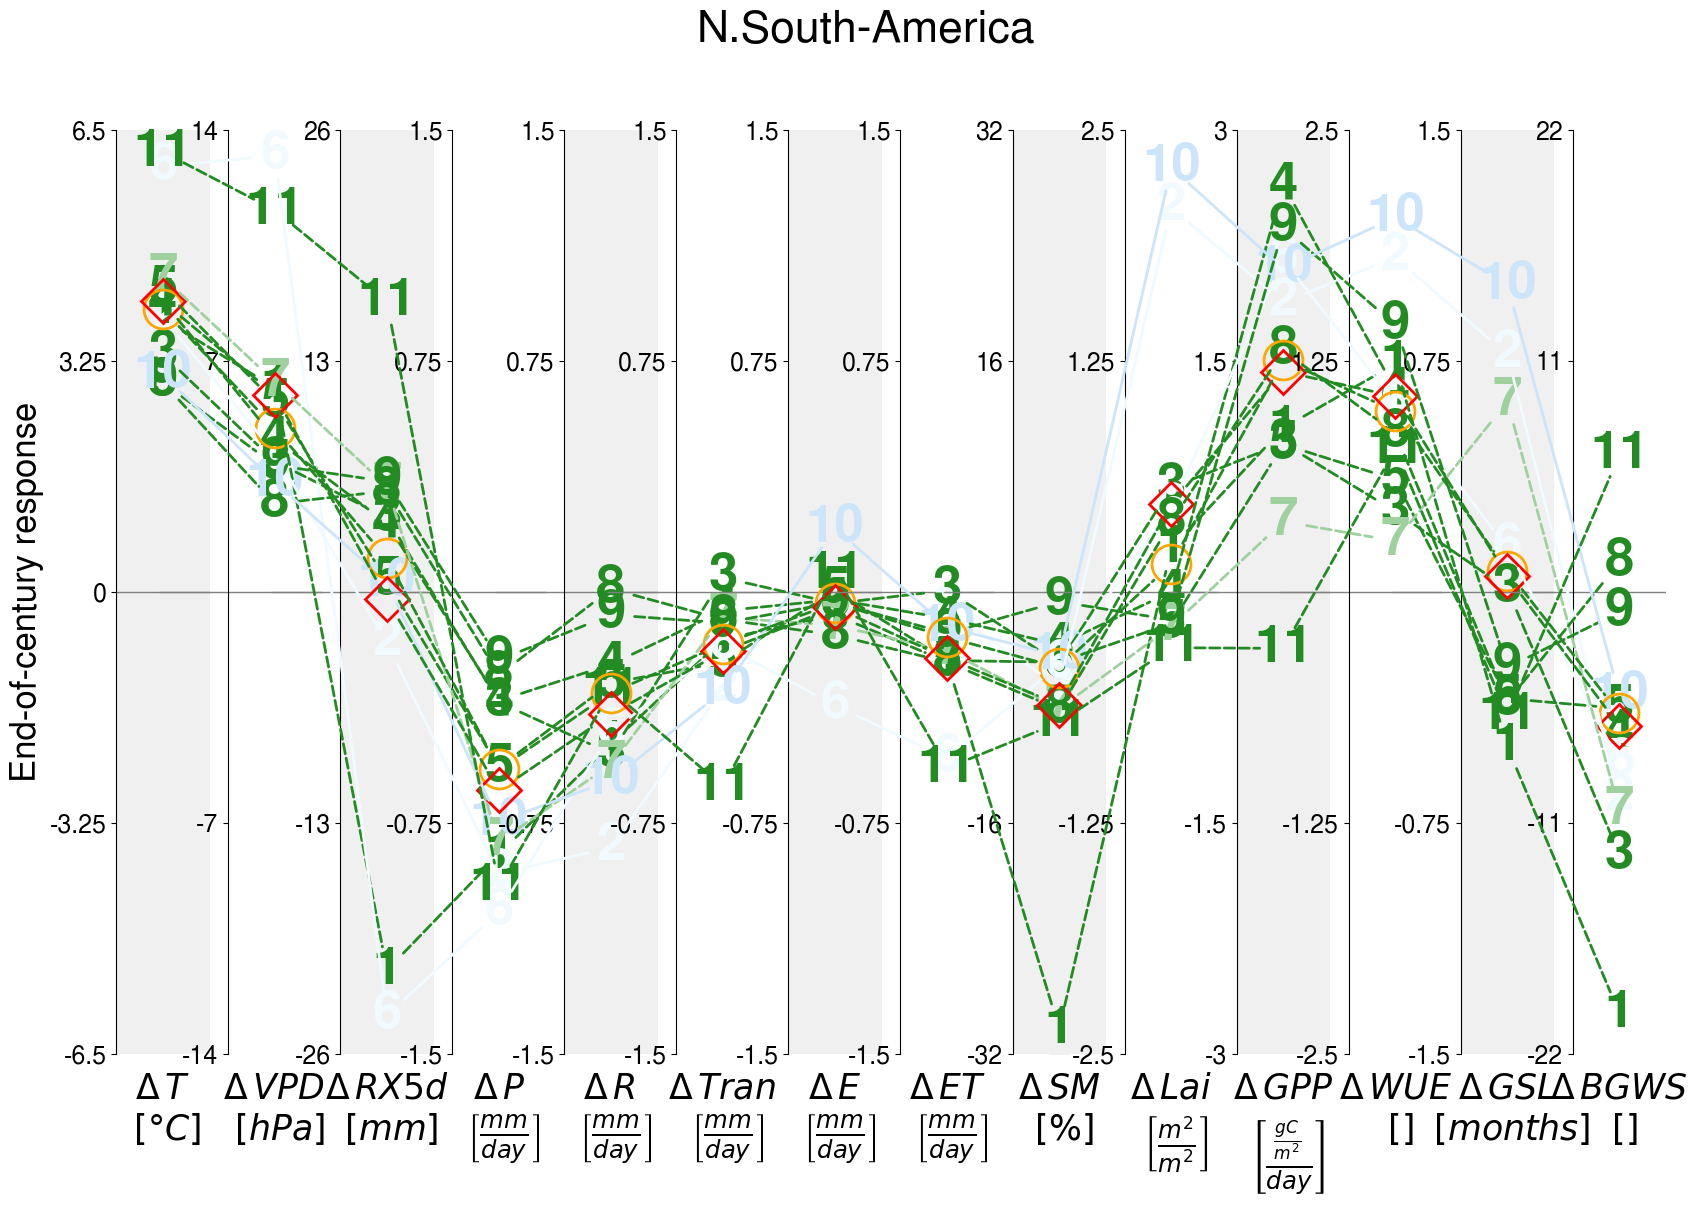

In [46]:
par_coor_plot.create_parallel_coordinate_plots(ds_dict_change_region_mean['ssp370-historical'], 
                   ds_dict_region_mean['historical'],
                   selected_indices=[10] , # 'ALL' 
                   selected_vars=selected_variables, 
                   common_scale_for_mm_day=True,
                   legend=False,
                   save_fig=False,
                   subdiv=False)

### Subregional Analysis

In [229]:
def fetch_region_and_subdivision_names(ds_dict_change, selected_region, subdiv_idx):
    """Fetch region and subdivision names for the plot title."""
    region_name = ds_dict_change[list(ds_dict_change.keys())[0]].coords['names'].sel(region=selected_region).item()
    subdivision_name = str(ds_dict_change[list(ds_dict_change.keys())[0]].coords['subdivision'][subdiv_idx].item())
    return region_name, subdivision_name

def calculate_global_min_max_subdivisions(ds_dict_change, variables, selected_region, mm_day_variables, use_common_scale_for_mm_day=True):
    """Calculate global max and min values for each variable across all subdivisions."""
    global_max_min_values = {}
    
    for var in variables:
        global_max = -np.inf
        global_min = np.inf
        for model_name, ds in ds_dict_change.items():
            for subdiv in ds.coords['subdivision']:
                if var in ds.data_vars:
                    value = ds[var].sel(region=selected_region, subdivision=subdiv).values.item()
                    if not np.isnan(value):
                        if use_common_scale_for_mm_day and var in mm_day_variables:
                            global_max = max(global_max, np.abs(value))
                            global_min = min(global_min, -np.abs(value))
                        else:
                            global_max = max(global_max, value)
                            global_min = min(global_min, value)
        global_max_min_values[var] = (global_min, global_max)

    return global_max_min_values

def plot_data_subdivisions(fig, axes, models, variables, ds_dict_change, ds_dict_historical, selected_region, subdiv_idx):
    """Iterate over models and variables to plot data using historical bgws value for color mapping."""
    for i, model_name in enumerate(models, start=1):
        ds_change = ds_dict_change[model_name]
        ds_historical = ds_dict_historical[model_name]  # Load historical data
        prev_xy = None

        for j, variable in enumerate(variables):
            if variable in ds_change.data_vars:
                value = ds_change[variable].sel(region=selected_region, subdivision=subdiv_idx).values.item()
                historical_bgws_value = ds_historical['bgws'].sel(region=selected_region, subdivision=subdiv_idx).values.item()
                
                color = bgws_cmap((historical_bgws_value - -0.1) / (0.1 - -0.1))  # Normalize historical bgws value
                current_xy = (j, value)
                
                if np.isnan(value):
                    prev_xy = None
                    continue

                if model_name.lower() == "ensemble mean":
                    axes[j].plot(j, value, 'D', mec='red', mfc='none', markersize=22, mew=2, zorder=5)
                elif model_name.lower() == "ensemble median":
                    axes[j].plot(j, value, 'o', mec='orange', mfc='none', markersize=28, mew=2, zorder=4)
                else:
                    dot_color = '#f0f0f0' if j % 2 == 0 else 'white'
                    axes[j].plot(j, value, 'o', color=dot_color, markersize=38, zorder=1)
                    axes[j].annotate(str(i), xy=current_xy, xytext=(0, 0), textcoords='offset points',
                                     fontsize=38, weight='bold', color=color,
                                     ha='center', va='center', zorder=2)

                if prev_xy is not None:
                    linestyle = '--' if historical_bgws_value < 0 else '-'
                    con = ConnectionPatch(xyA=prev_xy, xyB=current_xy, coordsA="data", coordsB="data",
                                          axesA=axes[j-1], axesB=axes[j],
                                          linestyle=linestyle, shrinkA=17, shrinkB=17, color=color, linewidth=2)
                    fig.add_artist(con)

                prev_xy = current_xy
            else:
                prev_xy = None

def plot_region_subd(fig, axes, models, selected_region, ds_dict_change, ds_dict_historical, variables, display_variables, change_type, subdiv_idx, use_common_scale_for_mm_day=True):
    """Main function to plot the region and subdivisions by combining the smaller functions."""
    region_name, subdivision_name = fetch_region_and_subdivision_names(ds_dict_change, selected_region, subdiv_idx)
    plot_title = f"{region_name} - Subdivision {subdivision_name}"
    fig.suptitle(plot_title, fontsize=32)

    mm_day_variables = ['pr', 'mrro', 'evspsbl', 'tran', 'evapo']
    global_max_min_values = calculate_global_min_max_subdivisions(
        ds_dict_change, variables, selected_region, mm_day_variables, use_common_scale_for_mm_day
    )

    adjust_axes(axes, variables, global_max_min_values, -np.inf, np.inf, display_variables, use_common_scale_for_mm_day, mm_day_variables)

    plot_data_subdivisions(fig, axes, models, variables, ds_dict_change, ds_dict_historical, selected_region, subdiv_idx)

In [ ]:
plot_region_subd(fig, axes, models, region_idx, ddict_change_regions_mean, ddict_historical_regions_mean, 
                        variables, display_variables, change_type, subdiv_idx, use_common_scale_for_mm_day=common_scale_for_mm_day) 


In [232]:
def plot_data_subdivisions(fig, axes, models, variables, ds_dict_change, ds_dict_historical, selected_region, subdiv_idx):
    """Iterate over models and variables to plot data using historical bgws value for color mapping."""
    for i, model_name in enumerate(models, start=1):
        ds_change = ds_dict_change[model_name]
        ds_historical = ds_dict_historical[model_name]  # Load historical data
        prev_xy = None

        for j, variable in enumerate(variables):
            if variable in ds_change.data_vars:
                try:
                    # Attempt to select the data
                    value = ds_change[variable].sel(region=selected_region, subdivision=subdiv_idx).values.item()
                    historical_bgws_value = ds_historical['bgws'].sel(region=selected_region, subdivision=subdiv_idx).values.item()

                    # Skip if value is NaN
                    if np.isnan(value) or np.isnan(historical_bgws_value):
                        continue

                    # Normalize historical bgws value
                    color = bgws_cmap((historical_bgws_value - -0.1) / (0.1 - -0.1))
                    current_xy = (j, value)

                    if model_name.lower() == "ensemble mean":
                        axes[j].plot(j, value, 'D', mec='red', mfc='none', markersize=22, mew=2, zorder=5)
                    elif model_name.lower() == "ensemble median":
                        axes[j].plot(j, value, 'o', mec='orange', mfc='none', markersize=28, mew=2, zorder=4)
                    else:
                        dot_color = '#f0f0f0' if j % 2 == 0 else 'white'
                        axes[j].plot(j, value, 'o', color=dot_color, markersize=38, zorder=1)
                        axes[j].annotate(str(i), xy=current_xy, xytext=(0, 0), textcoords='offset points',
                                         fontsize=38, weight='bold', color=color,
                                         ha='center', va='center', zorder=2)

                    if prev_xy is not None:
                        linestyle = '--' if historical_bgws_value < 0 else '-'
                        con = ConnectionPatch(xyA=prev_xy, xyB=current_xy, coordsA="data", coordsB="data",
                                              axesA=axes[j-1], axesB=axes[j],
                                              linestyle=linestyle, shrinkA=17, shrinkB=17, color=color, linewidth=2)
                        fig.add_artist(con)

                    prev_xy = current_xy

                except KeyError:
                    # Skip if the region or subdivision is not found
                    print(f"Skipping model {model_name}, variable {variable} for region {selected_region}, subdivision {subdiv_idx} due to missing data.")
                    continue
                except ValueError:
                    # Skip if the values are invalid (e.g., NaN values)
                    continue
            else:
                prev_xy = None


In [231]:
ds_dict_change_region_sub_mean['ssp370-historical']['Ensemble mean']['lai']

<xarray.DataArray 'lai' (subdivision: 2, region: 44)>
array([[ 0.53009622,  0.37878224,  0.31701304,  0.51777102,  0.61996208,
         0.4984038 ,  0.28872495,         nan,  0.39629033,  0.64431166,
         0.21669136,  0.17119854,  0.24390112,  0.24680556,  0.44315795,
         0.57155631,  0.50734111,  0.61649396,  0.25900414,  0.01901127,
         0.04668461, -0.09848958,  0.34925839,  0.39507573,  0.10081122,
        -0.16205502,  0.14461635,  0.40756054,  0.53006569,  0.58574568,
         0.56420438,  0.22197208,  0.14215876,  0.62180354,  1.09835893,
         0.03558007,  0.45315293,  0.85859485,  0.3429437 ,  0.03942151,
                nan,  0.52206725,  0.38010266,  0.43195656],
       [ 0.39041345,  0.41705969,  0.26396807,  0.30812864,  0.53534576,
         0.20414725,  0.22021962,  0.25042793, -0.22679741,  0.44305769,
         0.15334943,  0.19782391,  0.14639247,  0.20522053,  0.34792849,
         0.5919935 ,  0.41766488,  0.20921938,  0.15731306,  0.07003147,
         0.19977365,  0.15573627,  0.31361234,  0.33473558,  0.0483601 ,
        -0.0192165 ,  0.2487662 ,  0.47501412,  0.23036666,  0.45864781,
         0.5246083 ,  0.16985995,  0.19676913,  0.46524718,  0.79612063,
         0.04211578,  0.27680806,  0.58730327,  0.3062544 ,  0.05984672,
         0.39623563,  0.21249223,  0.2878879 ,  0.24301465]])
Coordinates:
  * subdivision  (subdivision) object 'Positive Historical BGWS' 'Negative Hi...
  * region       (region) int64 1 2 3 4 5 6 7 8 9 ... 36 37 38 39 40 41 42 43 0
    abbrevs      (region) <U4 'NWN' 'NEN' 'WNA' 'CNA' ... 'SAU' 'NZ' 'glob'
    names        (region) <U22 'N.W.North-America' ... 'Global'
Attributes:
    weights:  [0.5150380749100542, 0.5299192642332049, 0.5446390350150271, 0....

Skipping model BCC-CSM2-MR, variable tas for region 1, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable vpd for region 1, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable RX5day for region 1, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable pr for region 1, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrro for region 1, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable tran for region 1, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evapo for region 1, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evspsbl for region 1, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrso for region 1, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable lai for region 1, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable gpp for region 1, subdivision 0 due to missing data.

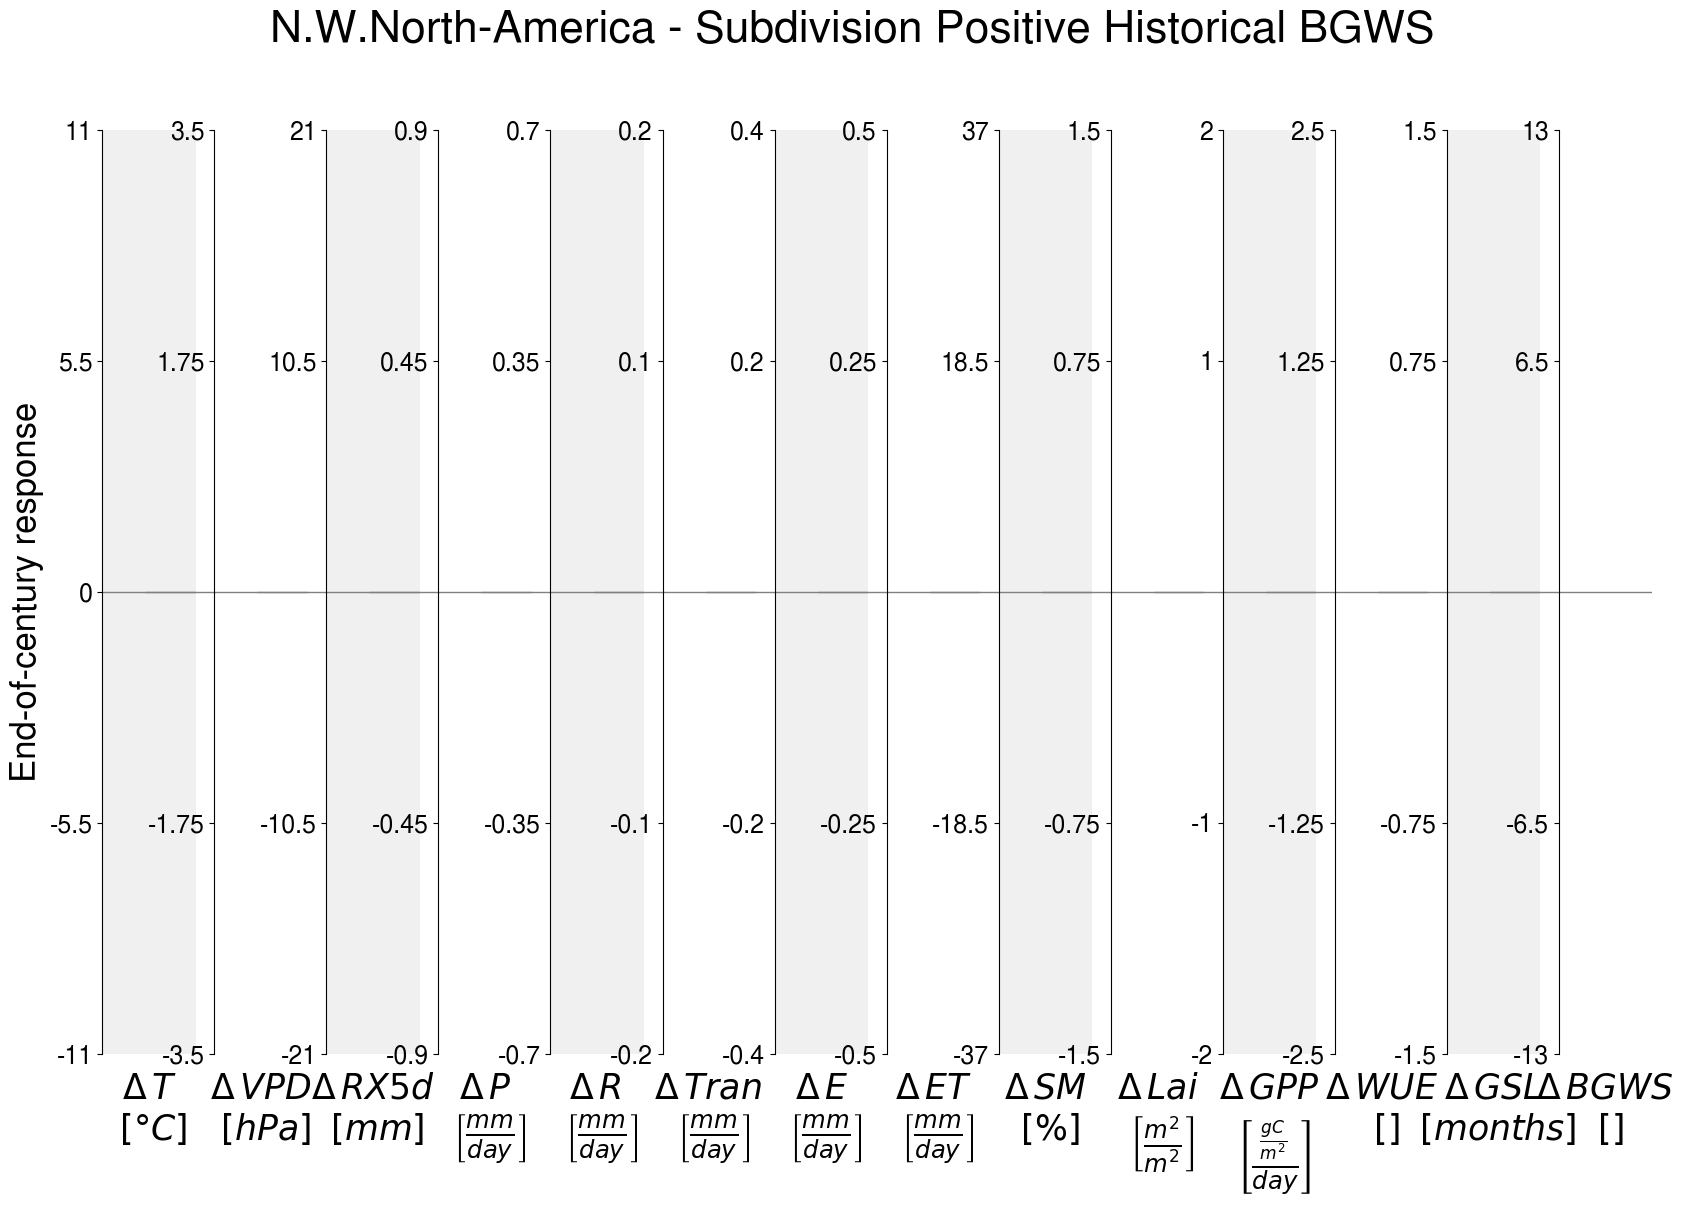

Skipping model BCC-CSM2-MR, variable tas for region 1, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable vpd for region 1, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable RX5day for region 1, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable pr for region 1, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable mrro for region 1, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable tran for region 1, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable evapo for region 1, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable evspsbl for region 1, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable mrso for region 1, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable lai for region 1, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable gpp for region 1, subdivision 1 due to missing data.

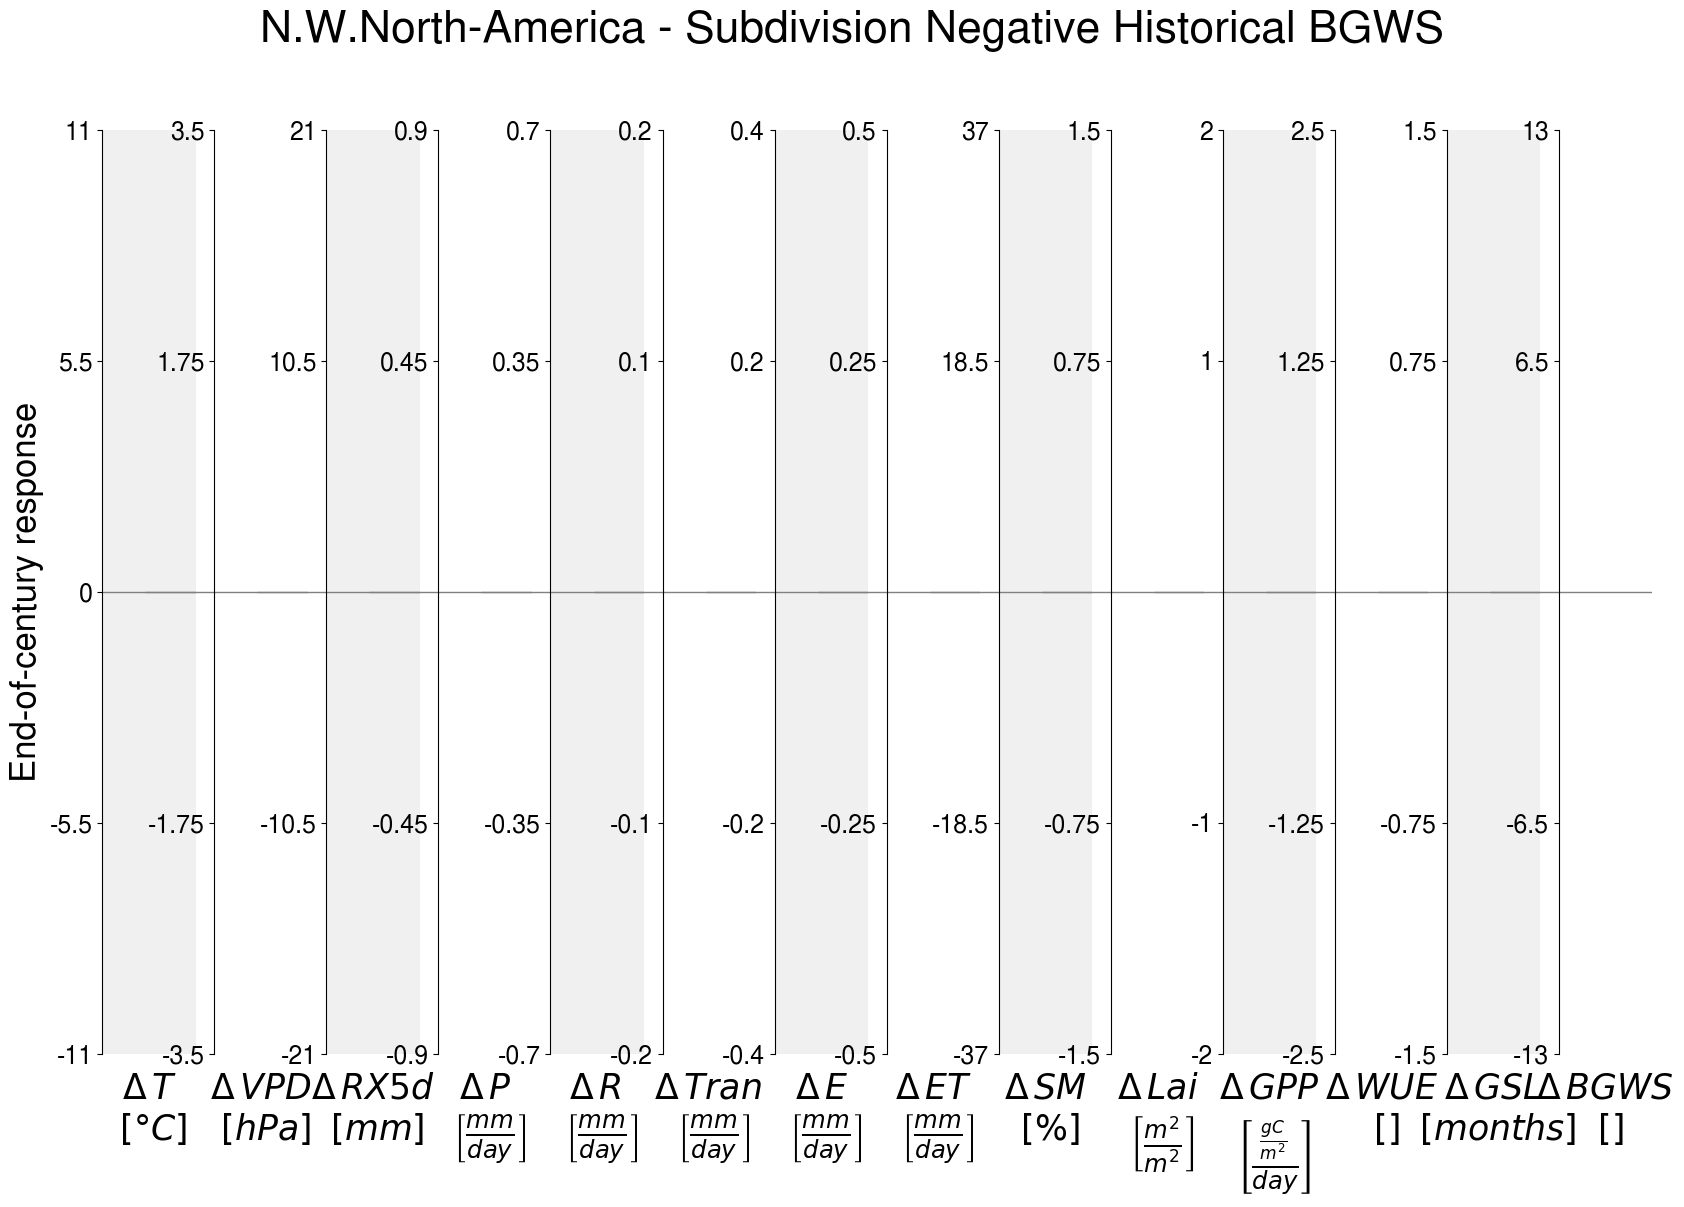

Skipping model BCC-CSM2-MR, variable tas for region 2, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable vpd for region 2, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable RX5day for region 2, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable pr for region 2, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrro for region 2, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable tran for region 2, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evapo for region 2, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evspsbl for region 2, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrso for region 2, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable lai for region 2, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable gpp for region 2, subdivision 0 due to missing data.

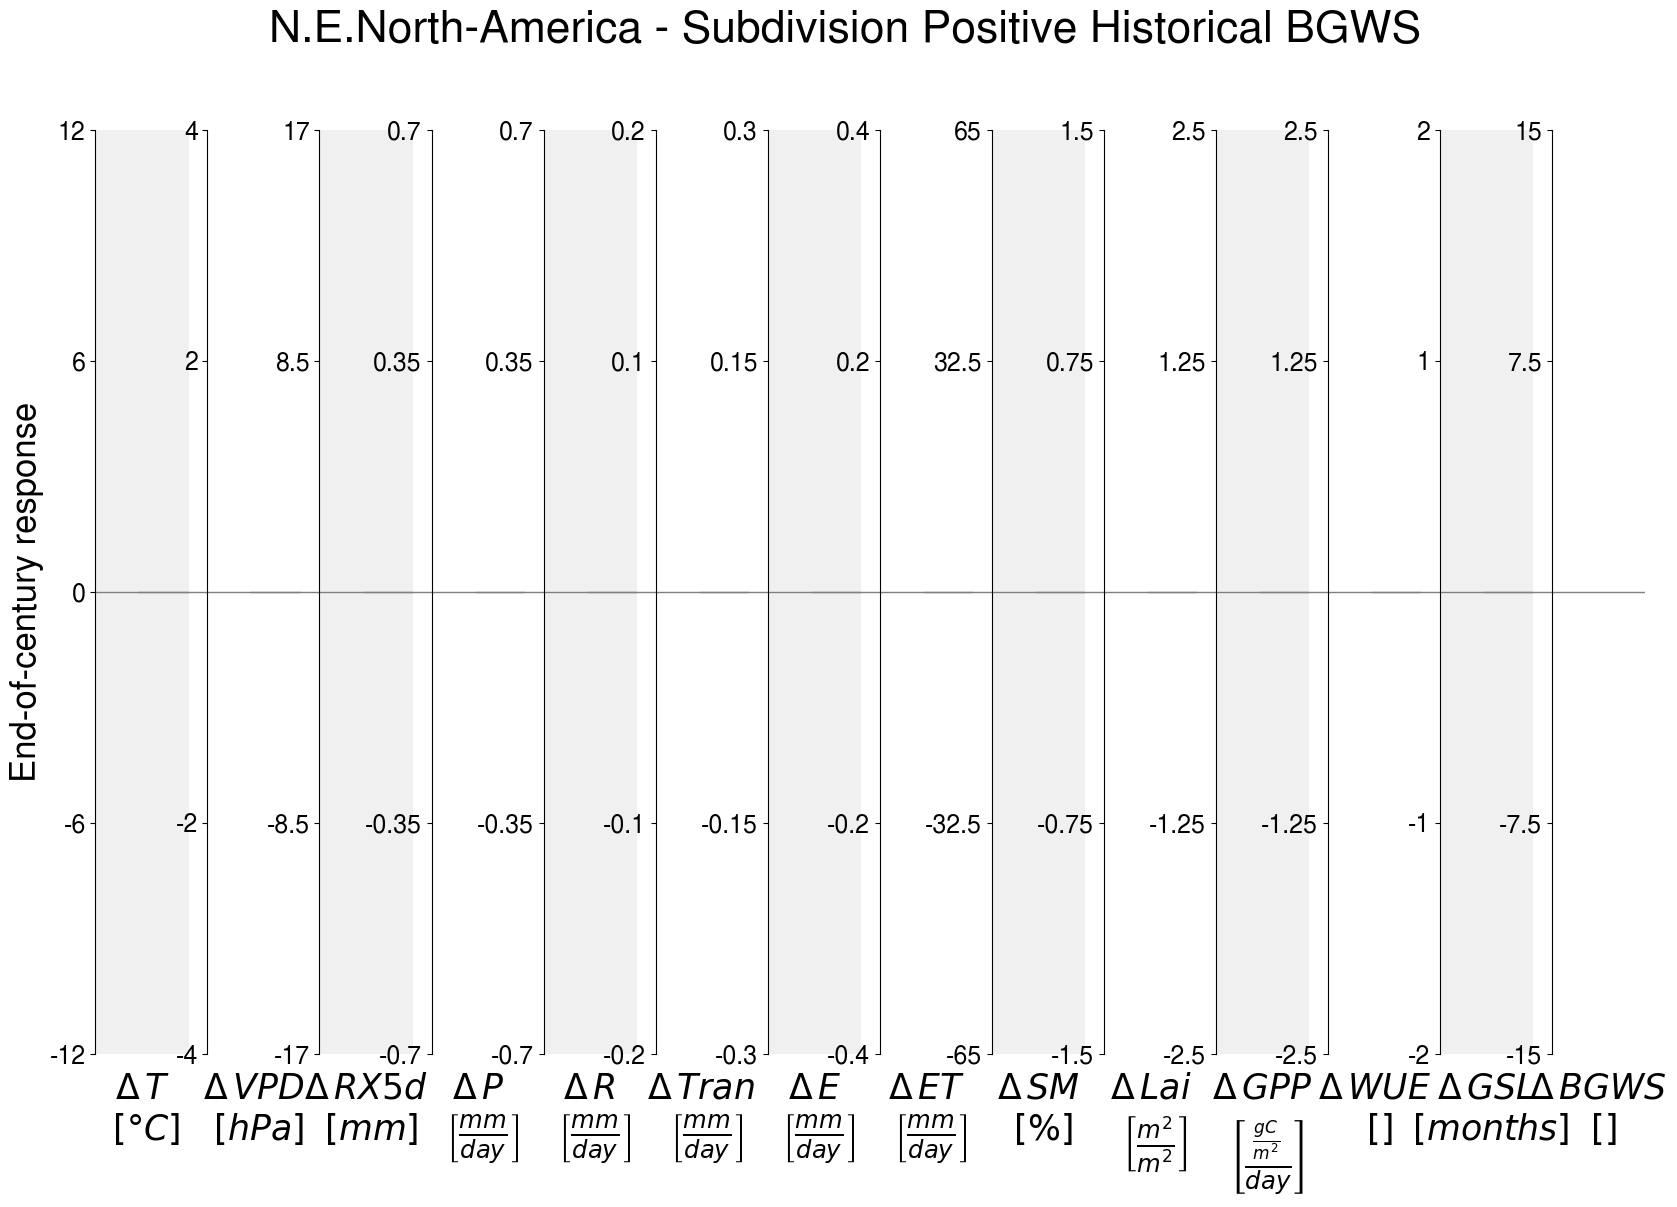

Skipping model BCC-CSM2-MR, variable tas for region 2, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable vpd for region 2, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable RX5day for region 2, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable pr for region 2, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable mrro for region 2, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable tran for region 2, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable evapo for region 2, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable evspsbl for region 2, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable mrso for region 2, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable lai for region 2, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable gpp for region 2, subdivision 1 due to missing data.

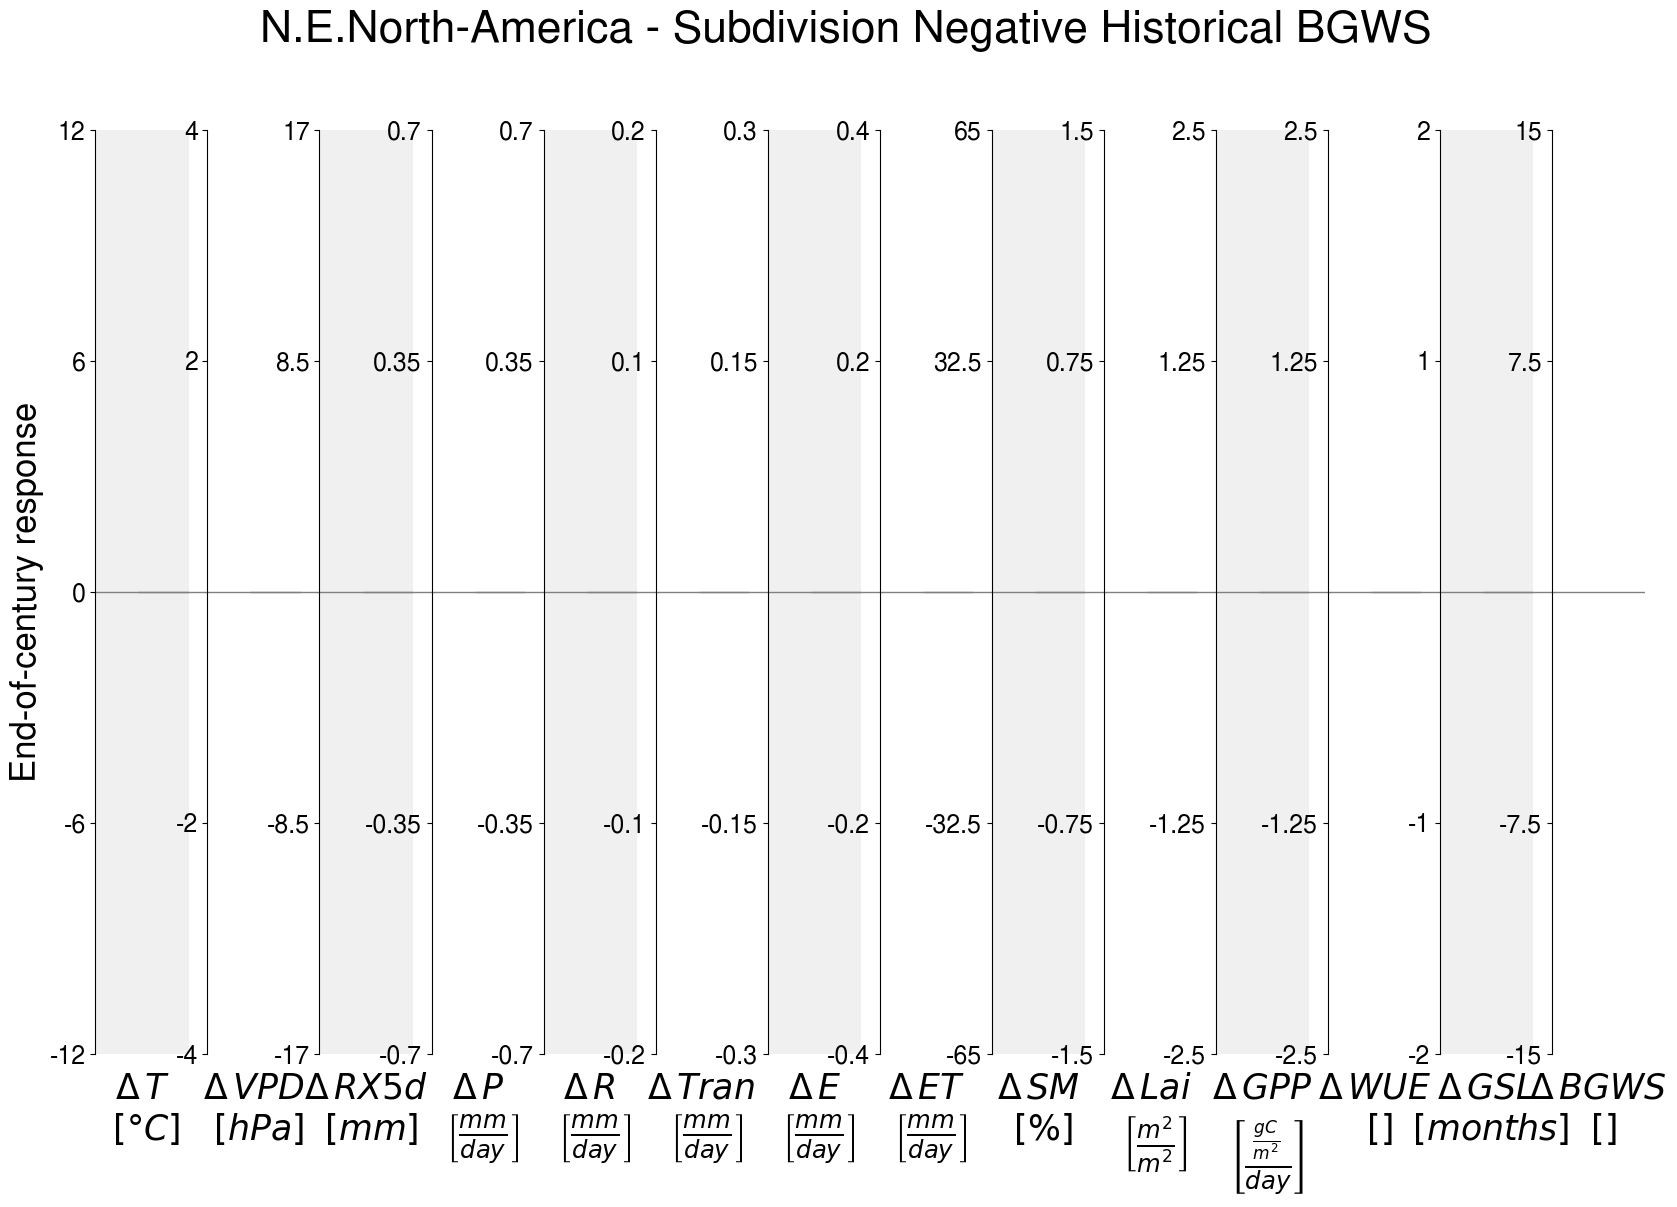

Skipping model BCC-CSM2-MR, variable tas for region 3, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable vpd for region 3, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable RX5day for region 3, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable pr for region 3, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrro for region 3, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable tran for region 3, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evapo for region 3, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evspsbl for region 3, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrso for region 3, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable lai for region 3, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable gpp for region 3, subdivision 0 due to missing data.

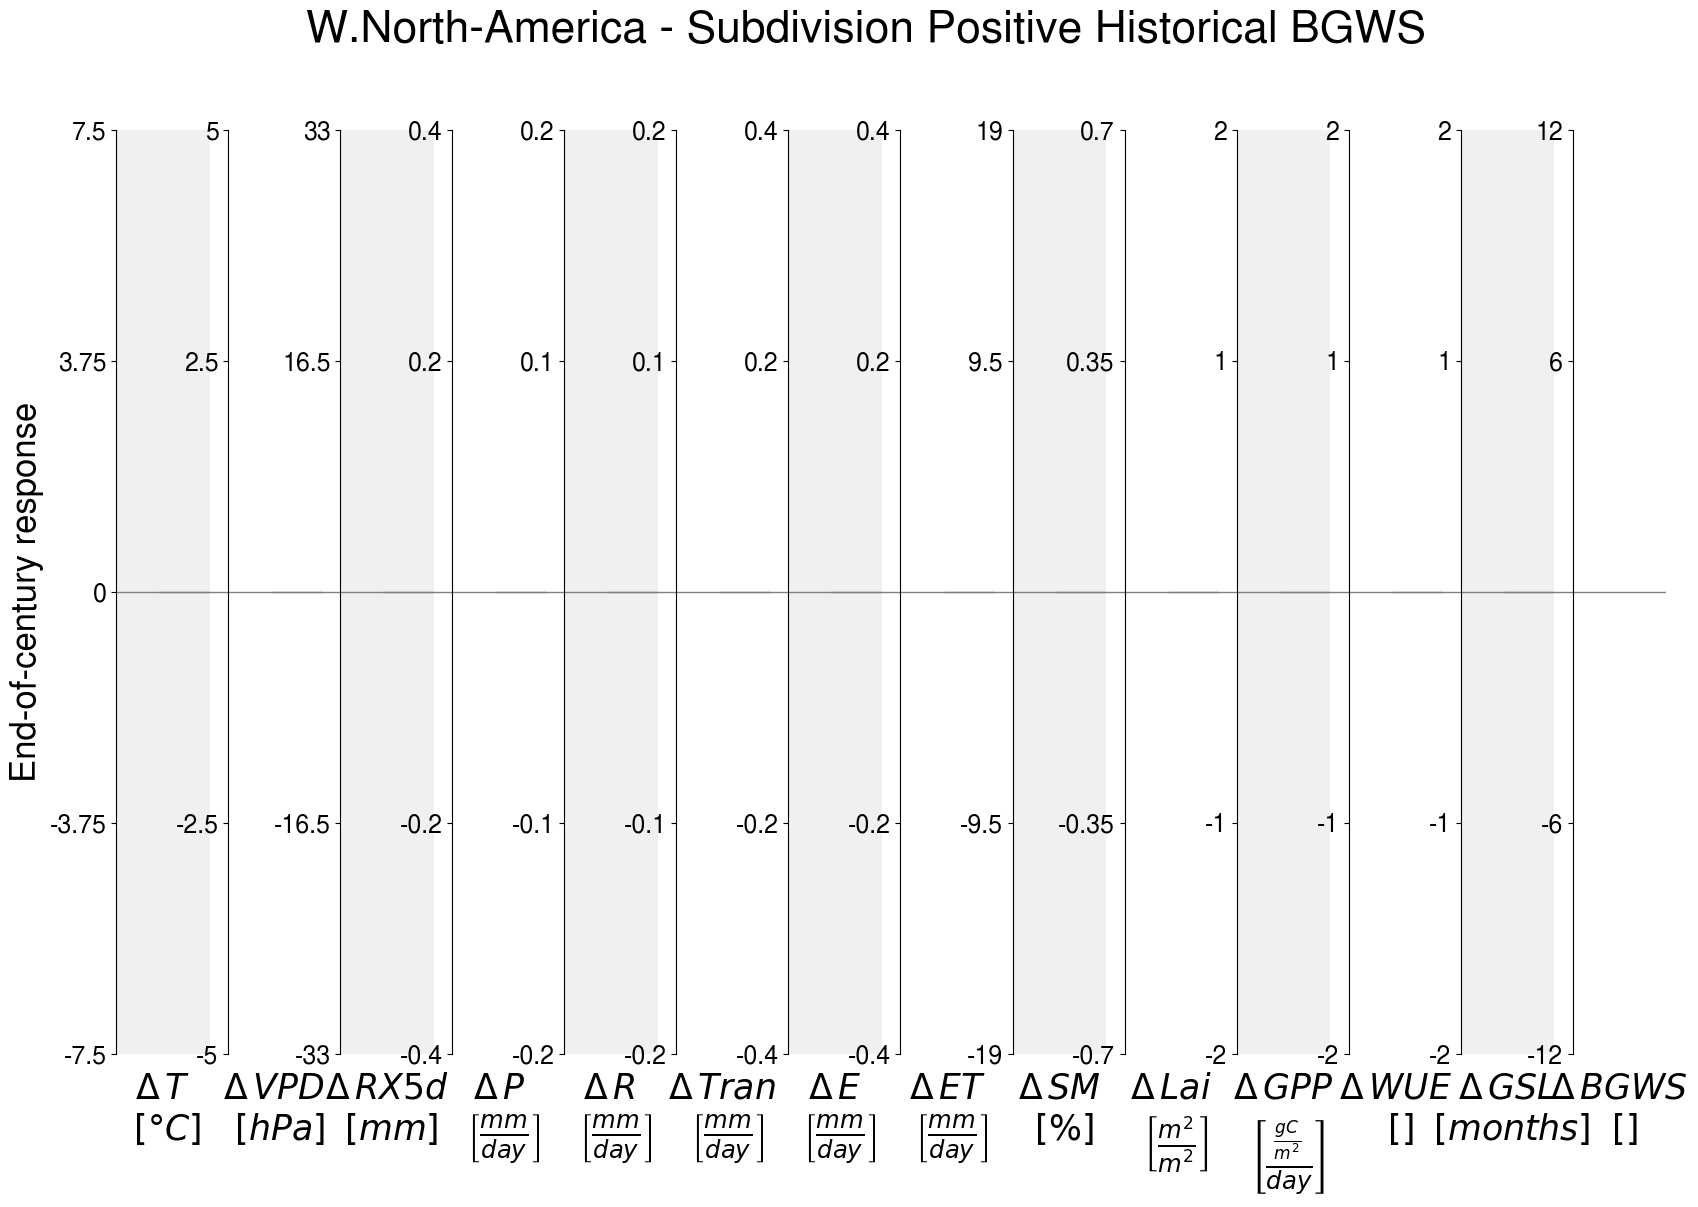

Skipping model BCC-CSM2-MR, variable tas for region 3, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable vpd for region 3, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable RX5day for region 3, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable pr for region 3, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable mrro for region 3, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable tran for region 3, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable evapo for region 3, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable evspsbl for region 3, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable mrso for region 3, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable lai for region 3, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable gpp for region 3, subdivision 1 due to missing data.

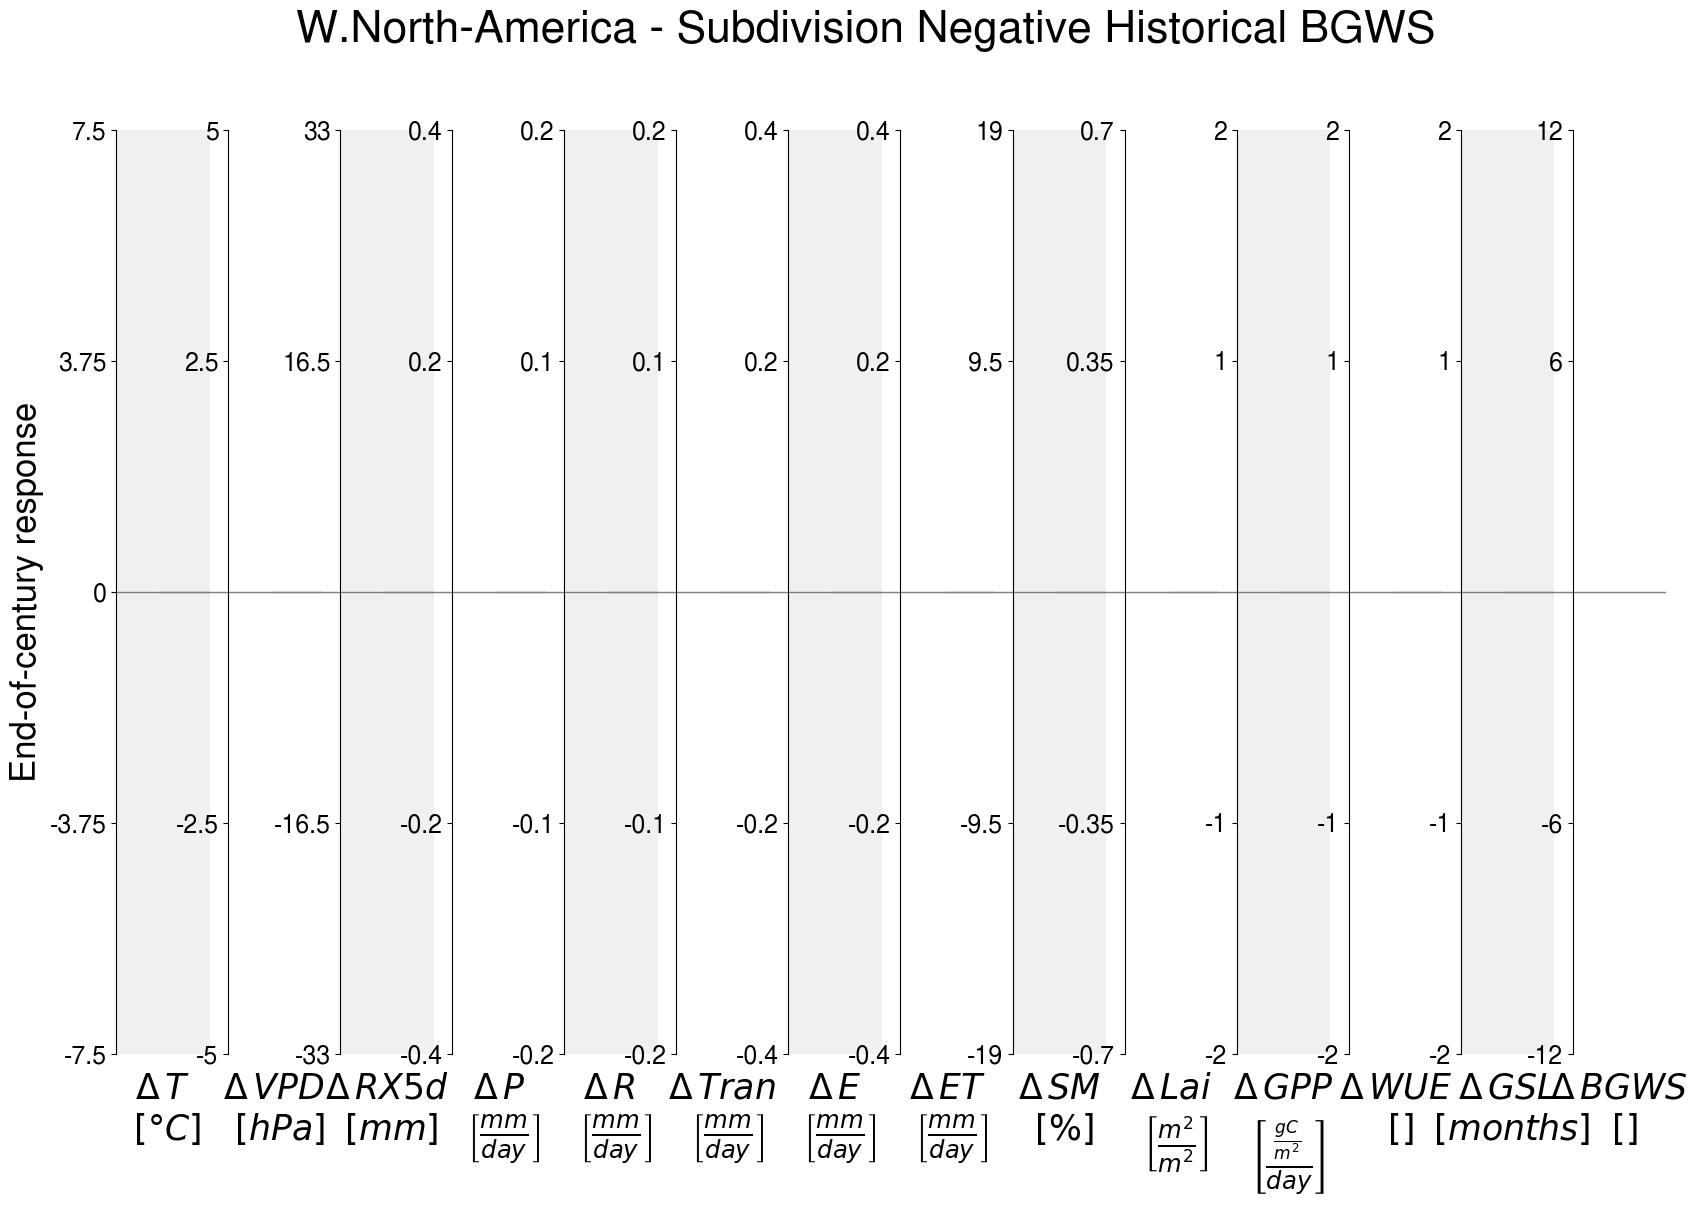

Skipping model BCC-CSM2-MR, variable tas for region 4, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable vpd for region 4, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable RX5day for region 4, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable pr for region 4, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrro for region 4, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable tran for region 4, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evapo for region 4, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evspsbl for region 4, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrso for region 4, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable lai for region 4, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable gpp for region 4, subdivision 0 due to missing data.

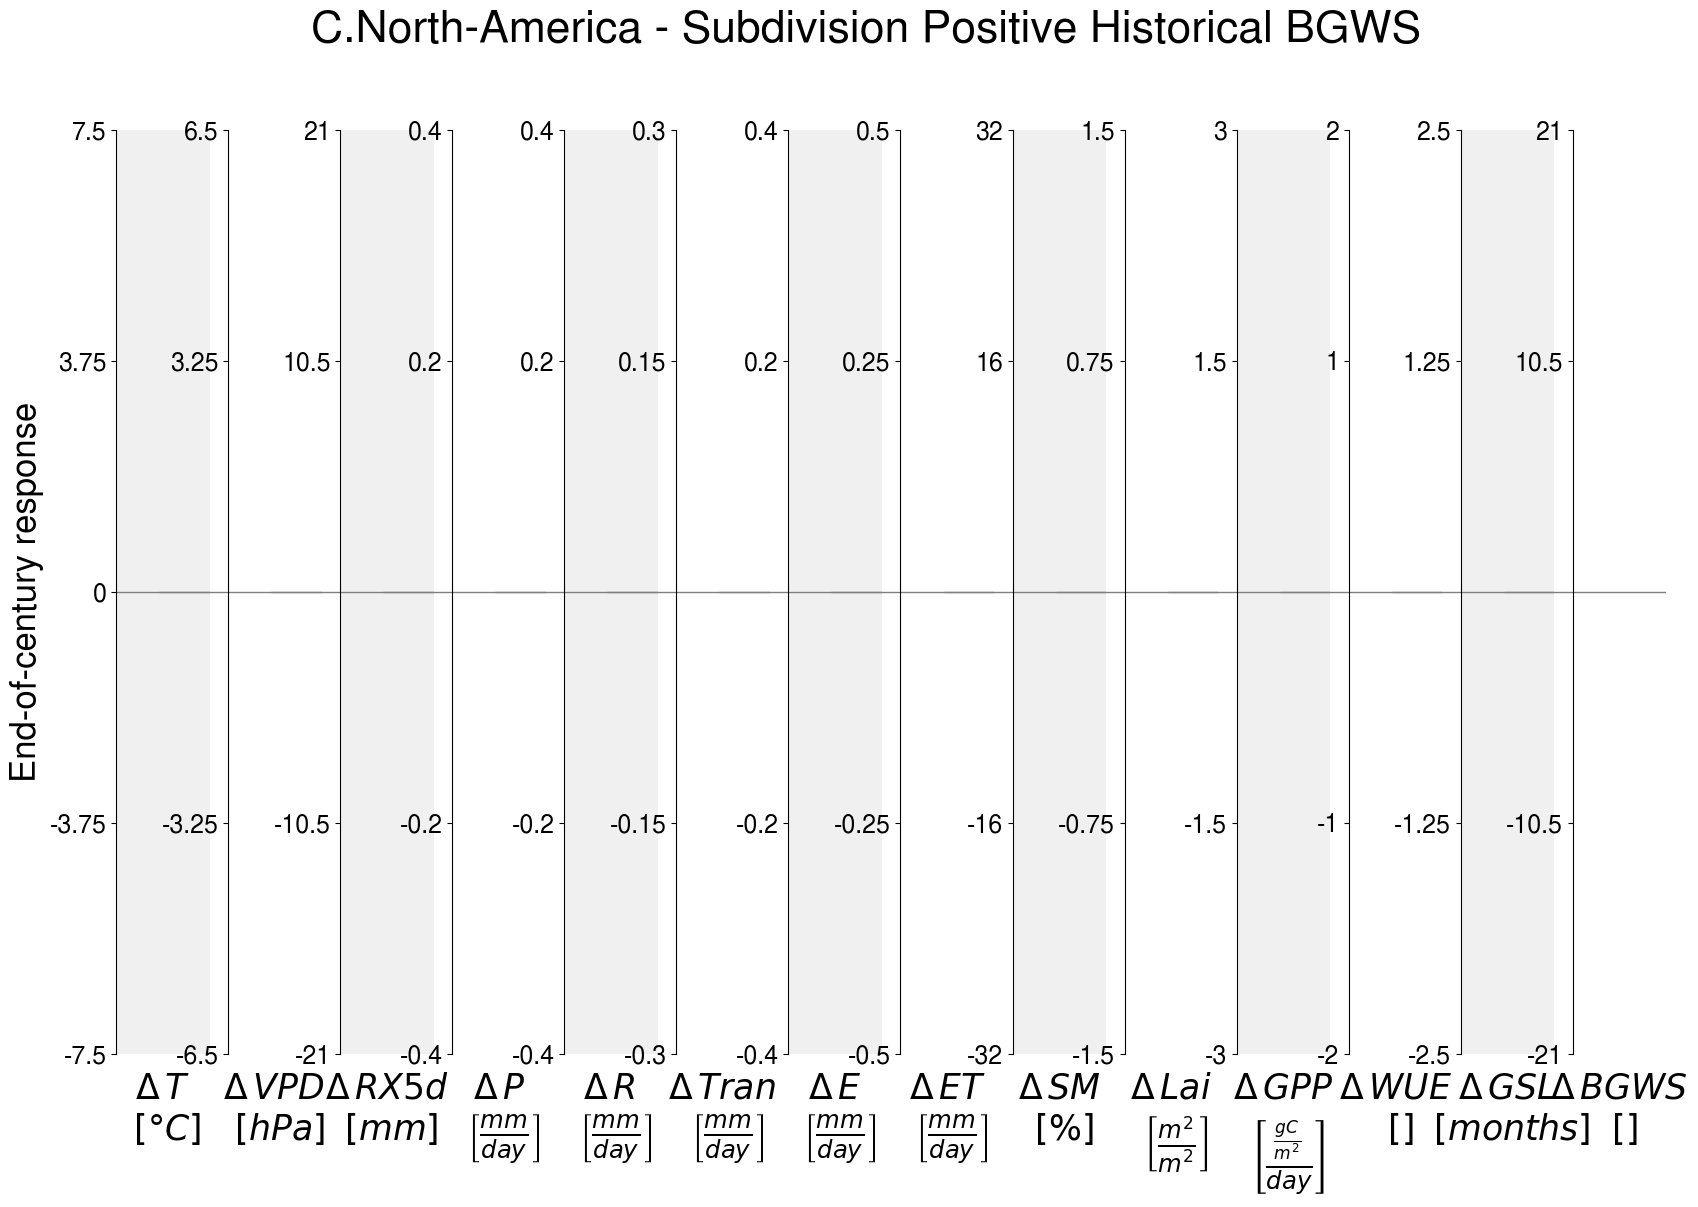

Skipping model BCC-CSM2-MR, variable tas for region 4, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable vpd for region 4, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable RX5day for region 4, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable pr for region 4, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable mrro for region 4, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable tran for region 4, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable evapo for region 4, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable evspsbl for region 4, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable mrso for region 4, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable lai for region 4, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable gpp for region 4, subdivision 1 due to missing data.

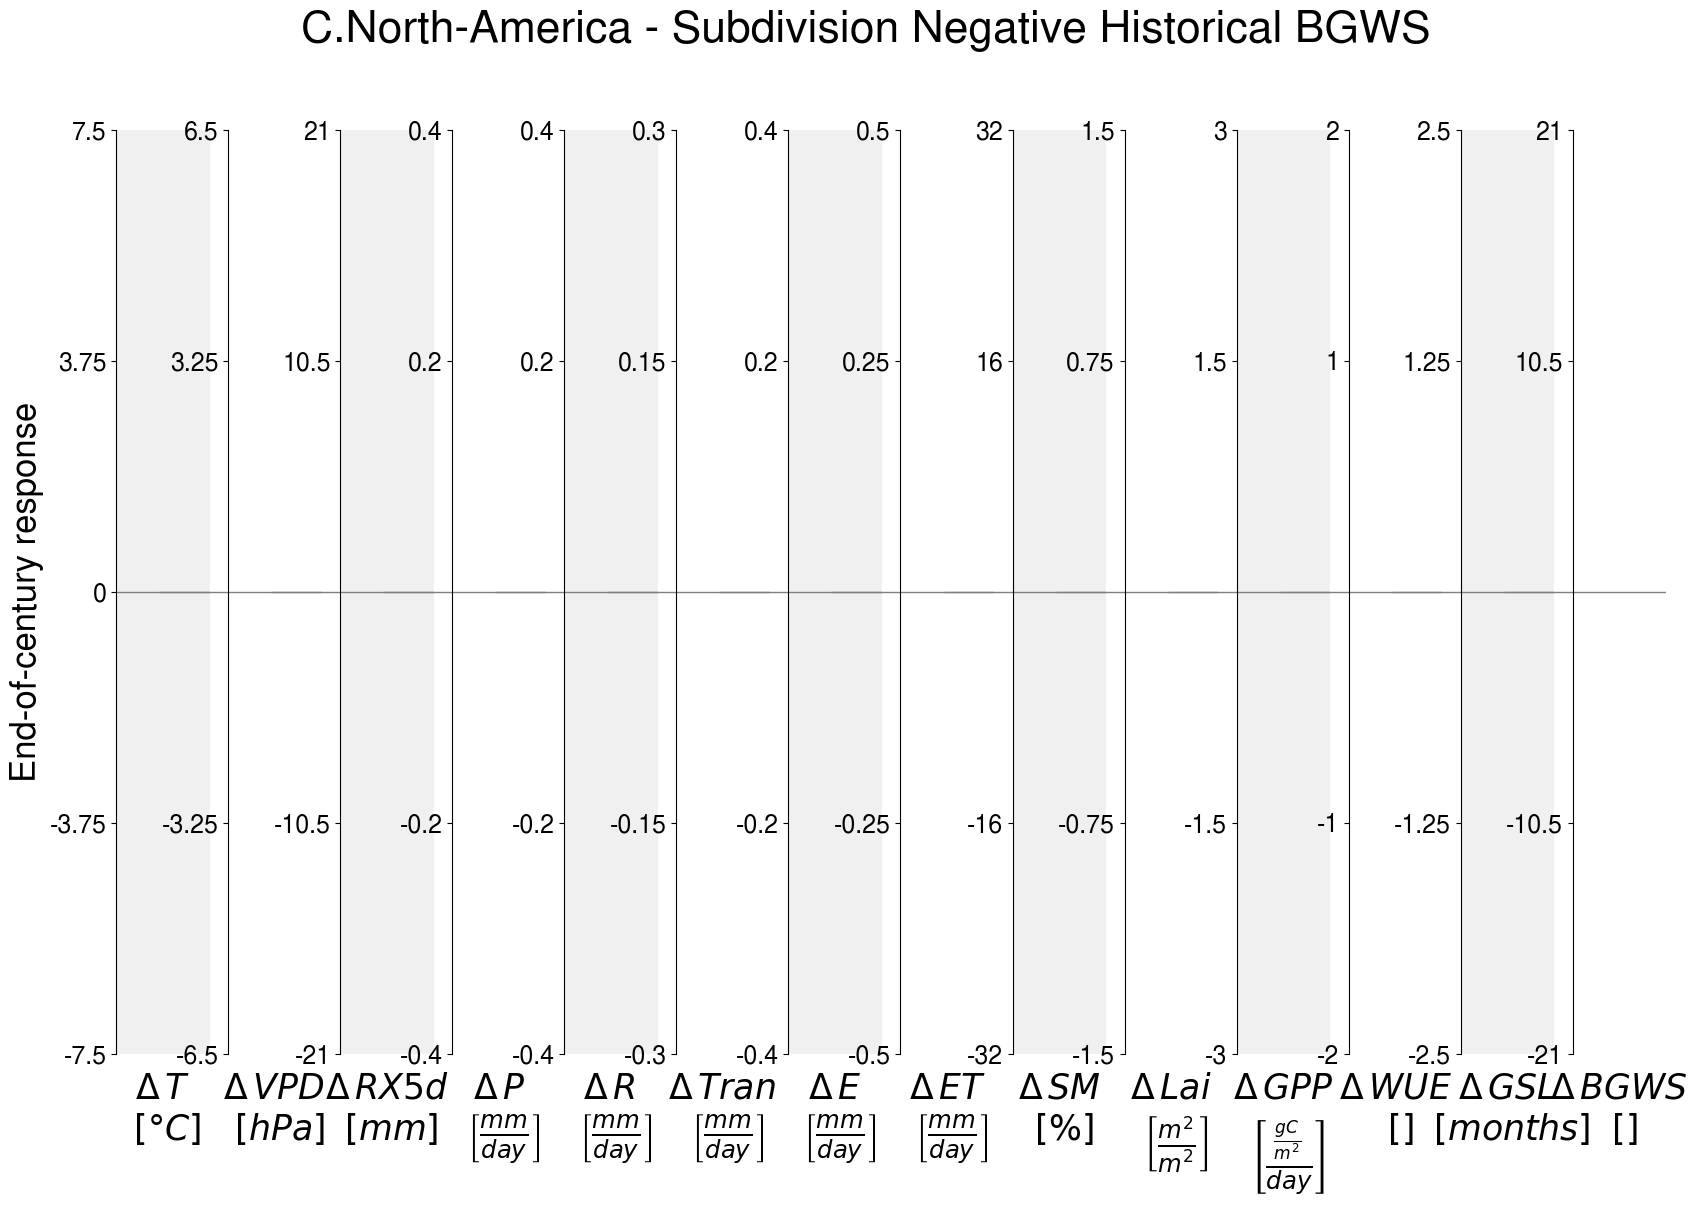

Skipping model BCC-CSM2-MR, variable tas for region 5, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable vpd for region 5, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable RX5day for region 5, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable pr for region 5, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrro for region 5, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable tran for region 5, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evapo for region 5, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evspsbl for region 5, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrso for region 5, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable lai for region 5, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable gpp for region 5, subdivision 0 due to missing data.

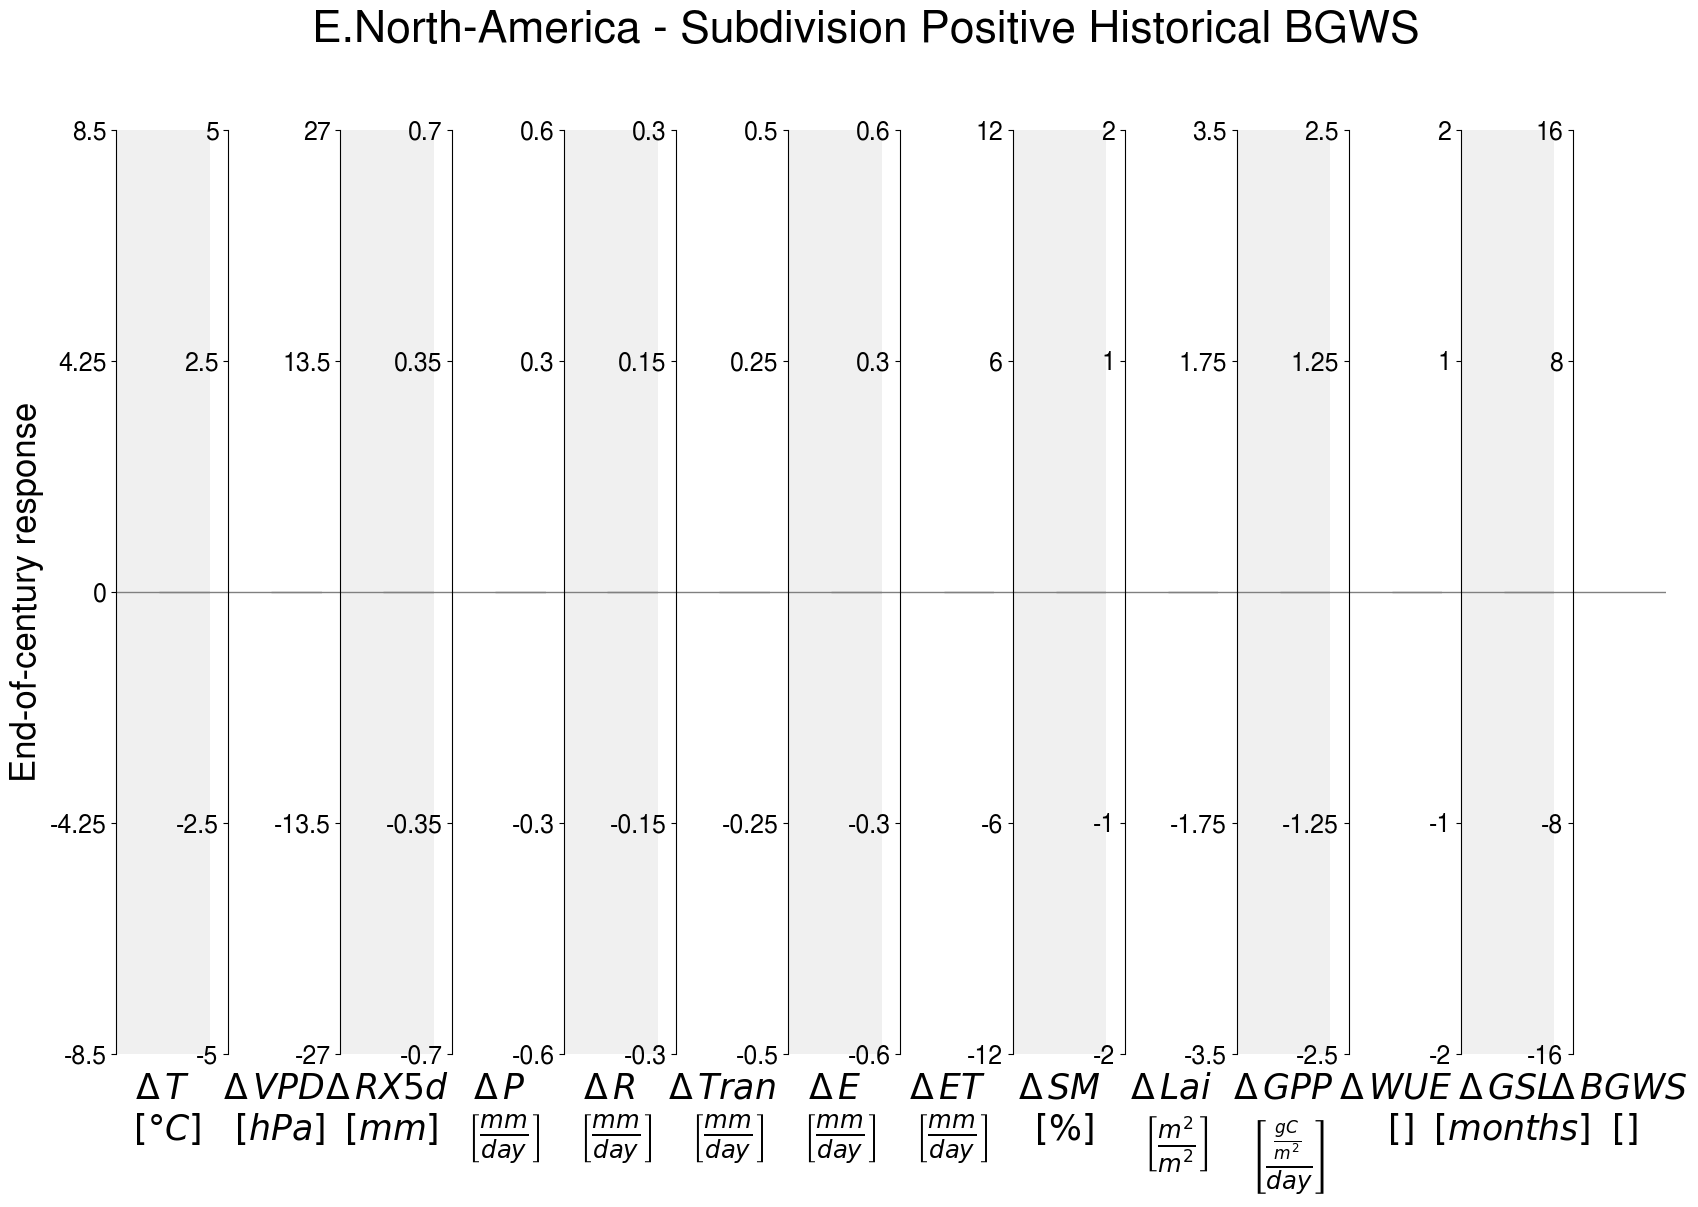

Skipping model BCC-CSM2-MR, variable tas for region 5, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable vpd for region 5, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable RX5day for region 5, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable pr for region 5, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable mrro for region 5, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable tran for region 5, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable evapo for region 5, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable evspsbl for region 5, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable mrso for region 5, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable lai for region 5, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable gpp for region 5, subdivision 1 due to missing data.

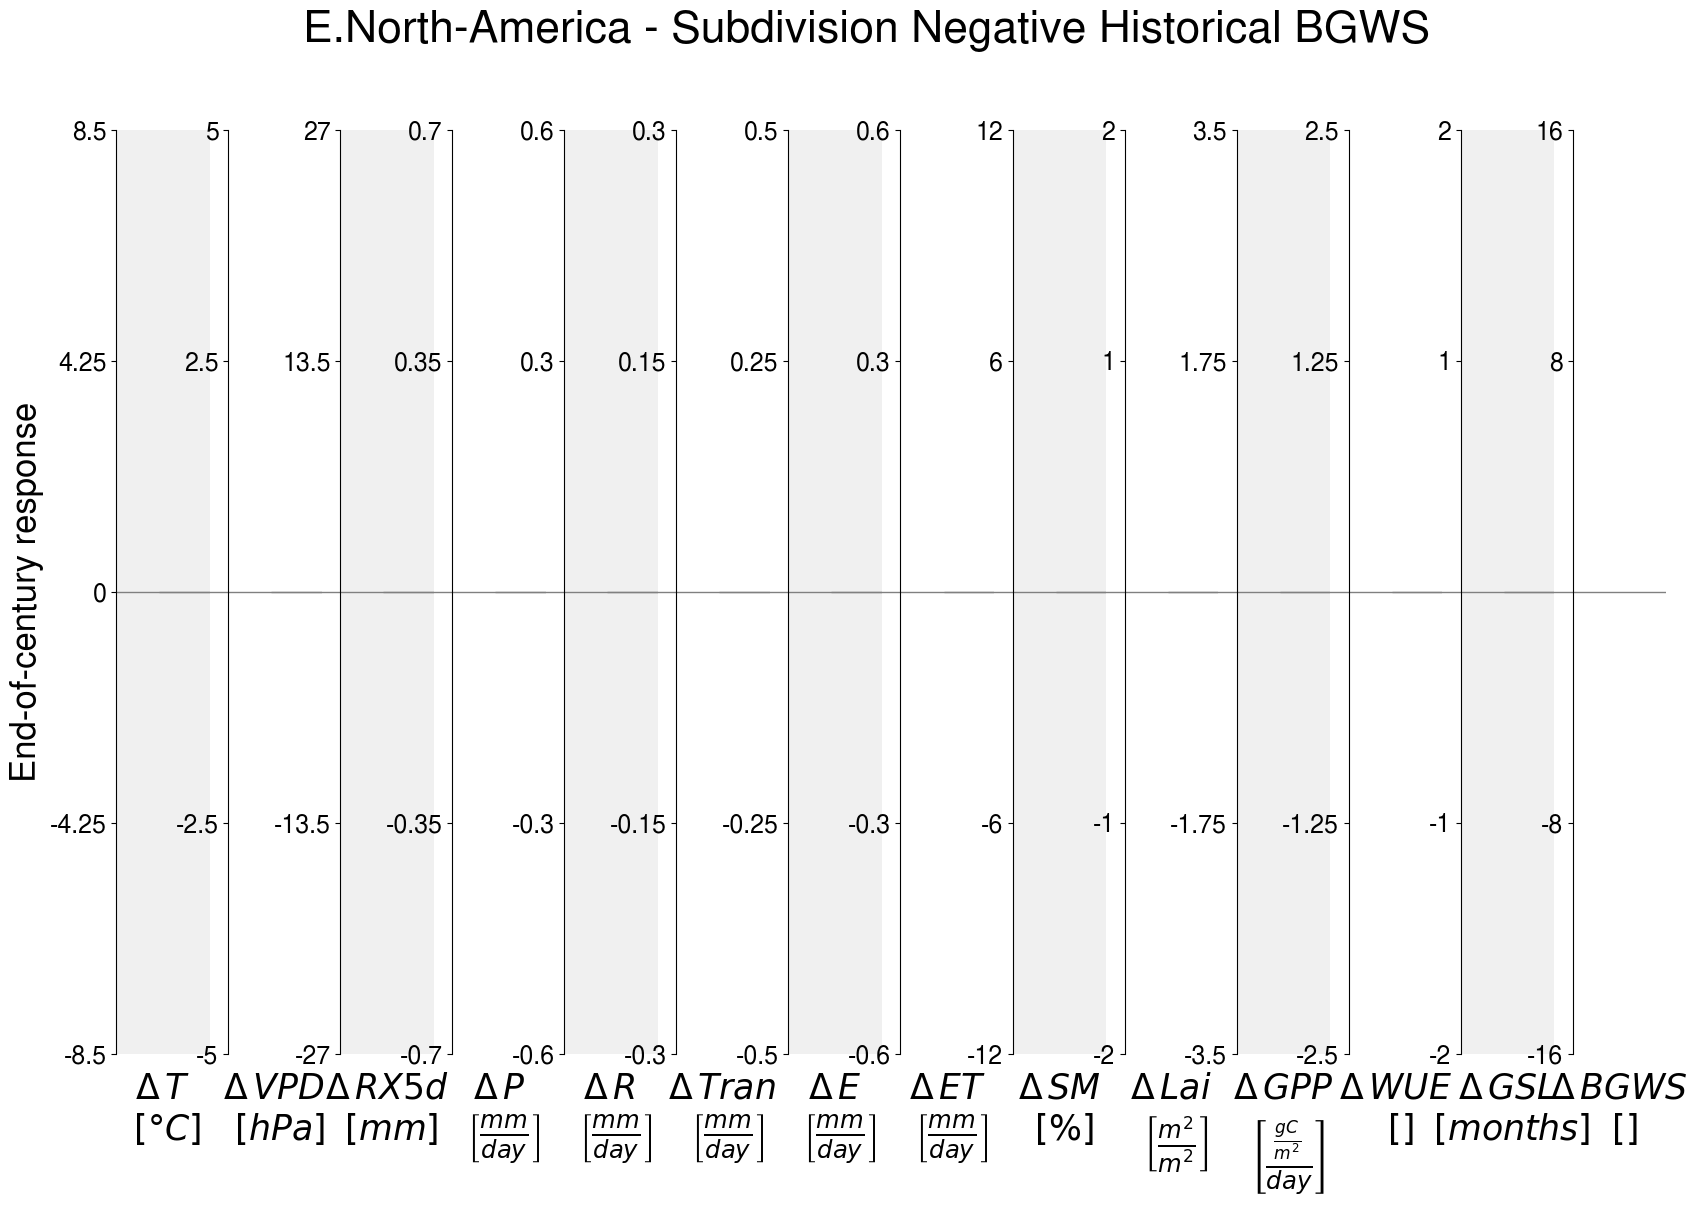

Skipping model BCC-CSM2-MR, variable tas for region 6, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable vpd for region 6, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable RX5day for region 6, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable pr for region 6, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrro for region 6, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable tran for region 6, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evapo for region 6, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evspsbl for region 6, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrso for region 6, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable lai for region 6, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable gpp for region 6, subdivision 0 due to missing data.

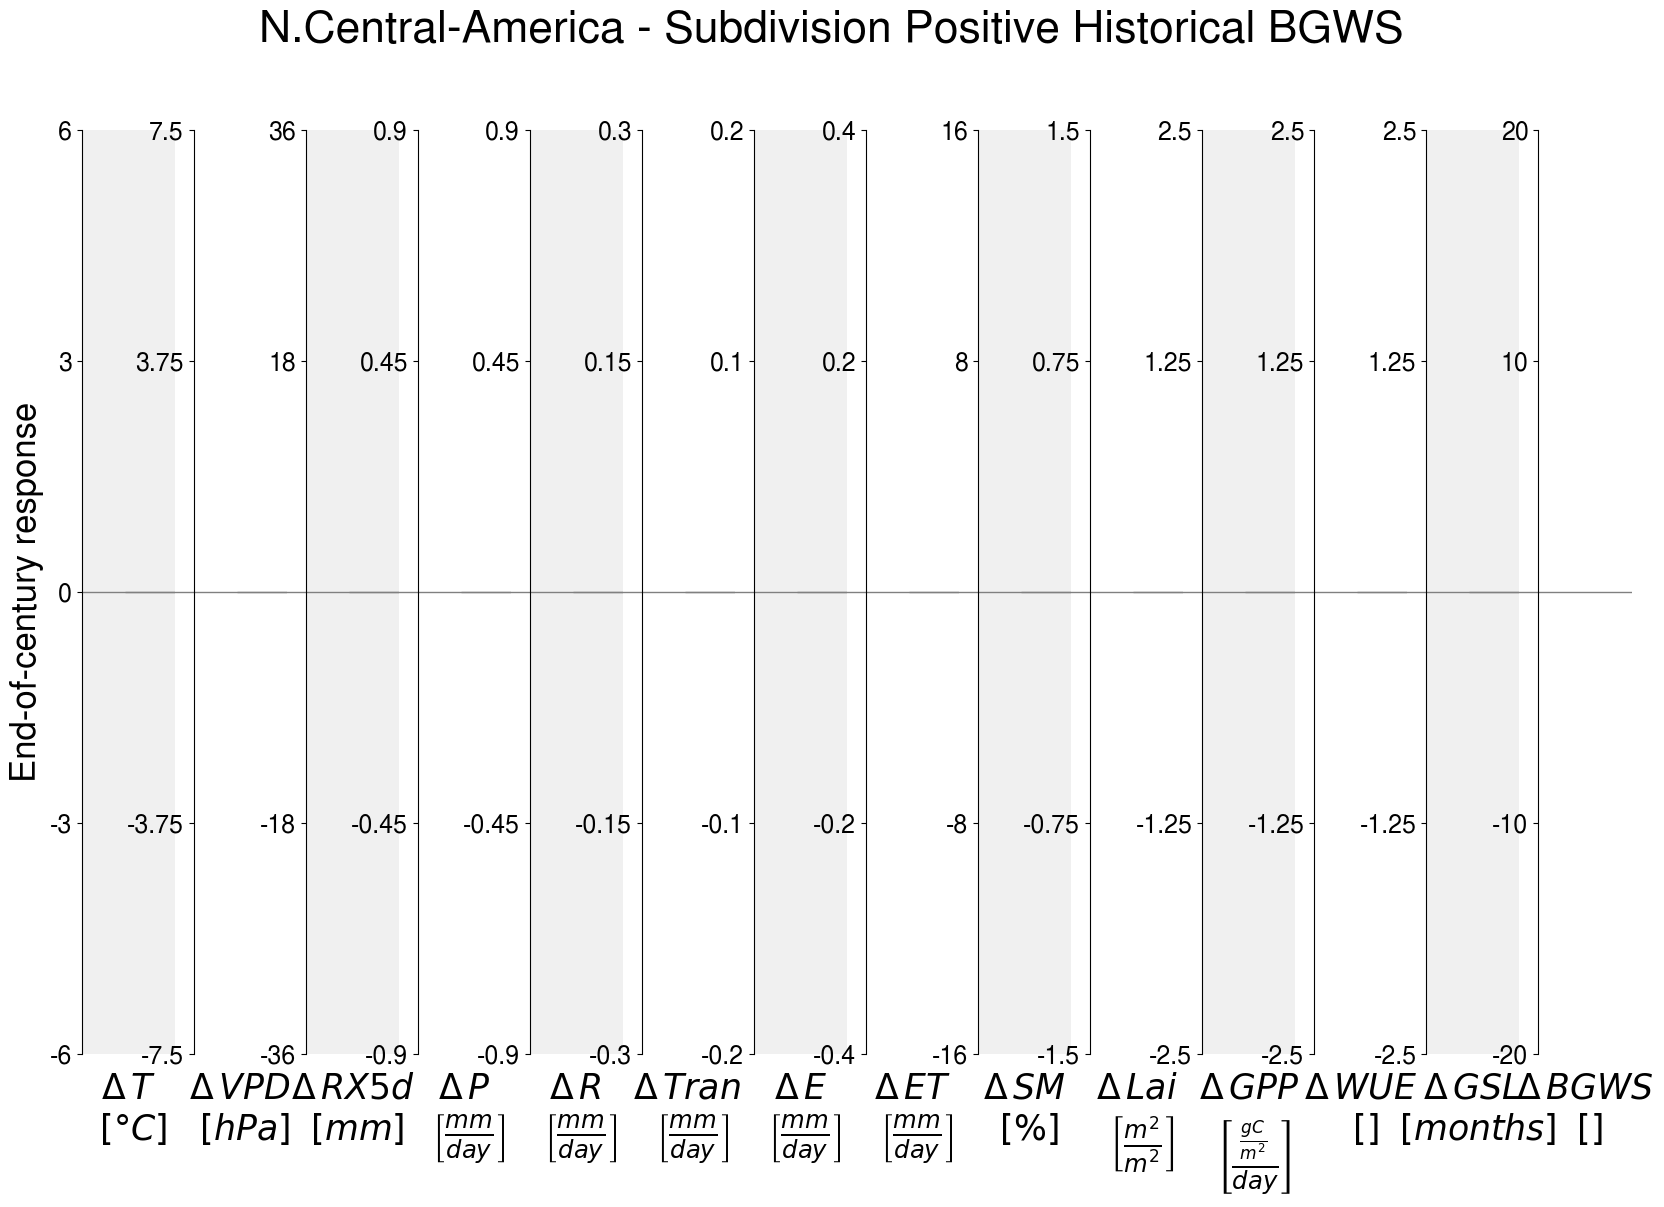

Skipping model BCC-CSM2-MR, variable tas for region 6, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable vpd for region 6, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable RX5day for region 6, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable pr for region 6, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable mrro for region 6, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable tran for region 6, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable evapo for region 6, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable evspsbl for region 6, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable mrso for region 6, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable lai for region 6, subdivision 1 due to missing data.
Skipping model BCC-CSM2-MR, variable gpp for region 6, subdivision 1 due to missing data.

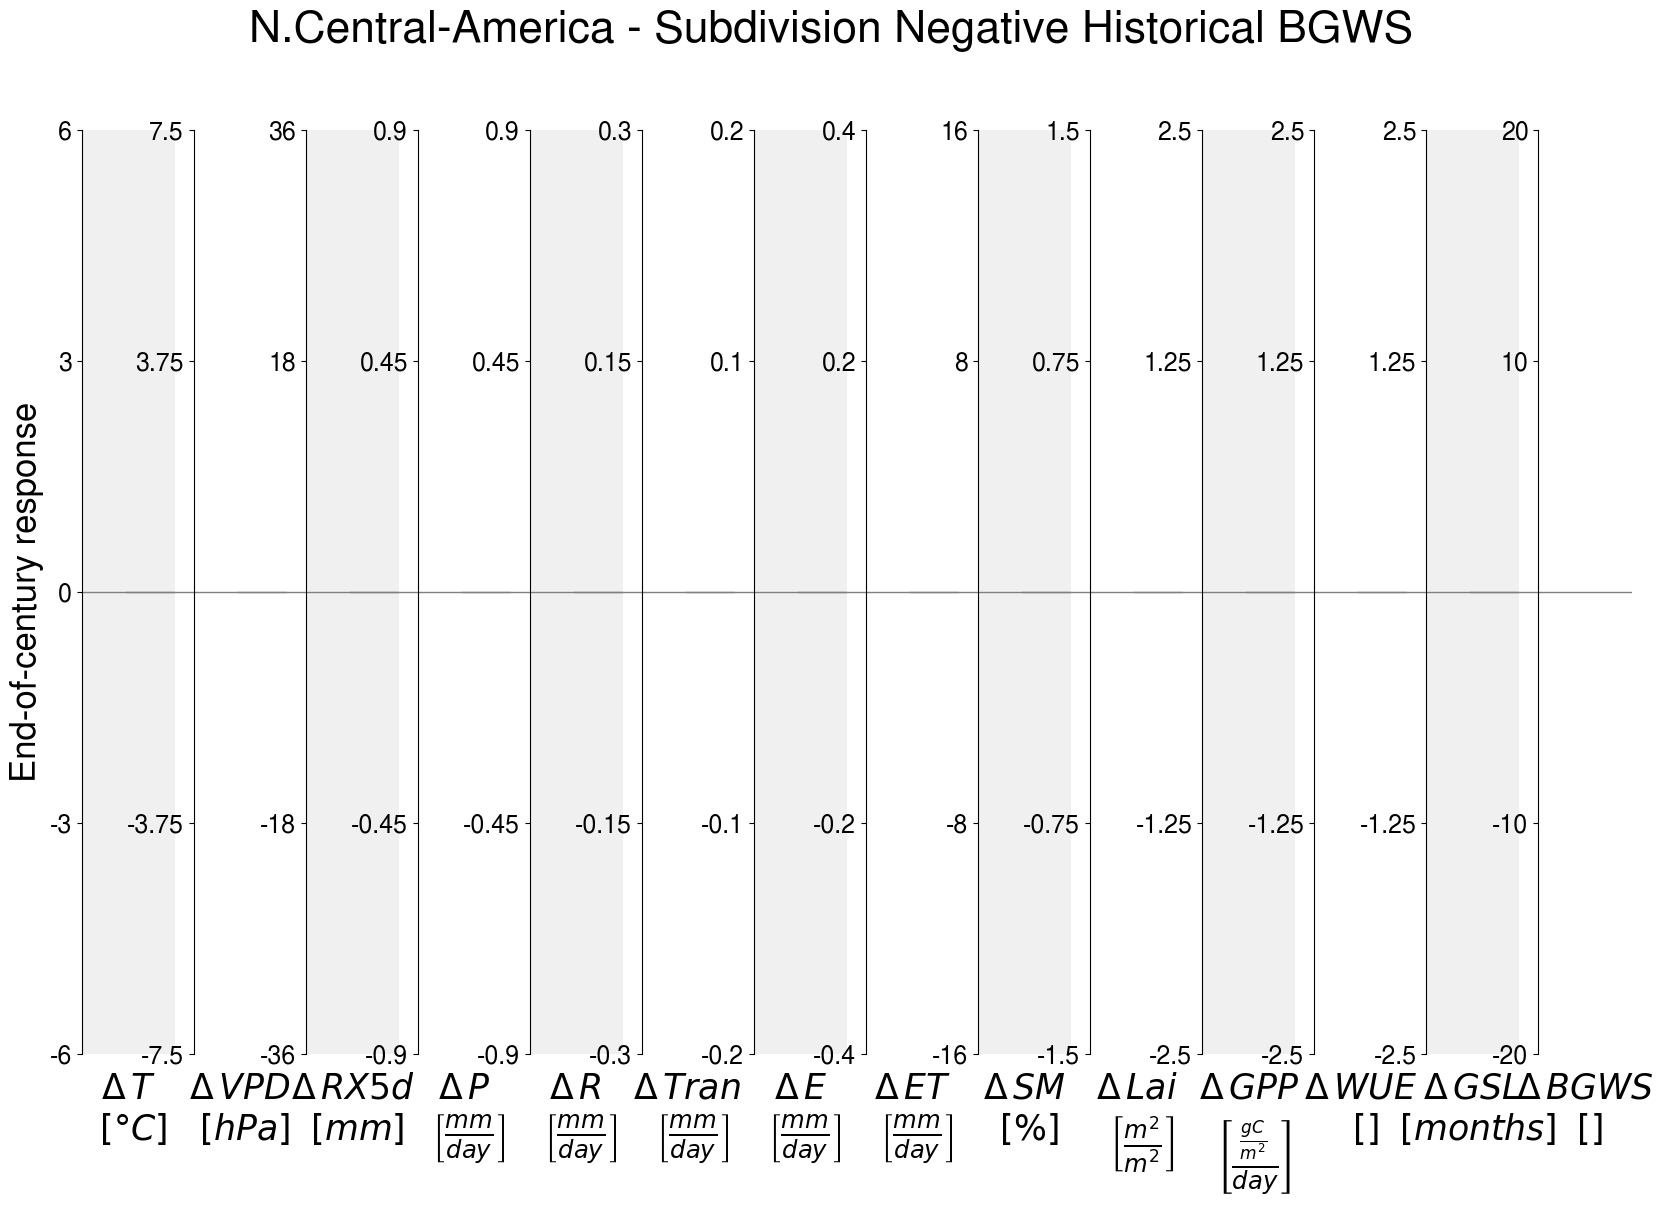

Skipping model BCC-CSM2-MR, variable tas for region 7, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable vpd for region 7, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable RX5day for region 7, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable pr for region 7, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrro for region 7, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable tran for region 7, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evapo for region 7, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable evspsbl for region 7, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable mrso for region 7, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable lai for region 7, subdivision 0 due to missing data.
Skipping model BCC-CSM2-MR, variable gpp for region 7, subdivision 0 due to missing data.

In [ ]:
plot_region_change(ds_dict_change_region_sub_mean['ssp370-historical'], 
                   ds_dict_region_sub_mean['historical'], 
                   selected_indices='ALL', 
                   selected_vars=selected_variables, 
                   common_scale_for_mm_day=False,
                   legend=False,
                   save_fig=False,
                   subdiv=True)

In [ ]:
plot_region_change(ds_dict_regions_change[list(ds_dict_regions_change.keys())[0]], 
                   selected_indices='ALL', 
                   selected_vars=selected_variables, 
                   common_scale_for_mm_day=False,
                   legend=False,
                   save_fig=False,
                   subdiv=False)

In [ ]:
# Changes:
# Legend smaller, units and x-axis in generak bigger